# Simulation of ratial sampling

Import the required libraries and the image data

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import sigpy.mri
import sigpy.plot

sitk_t1=sitk.ReadImage('../files/t1.nii.gz')
t1=sitk.GetArrayFromImage(sitk_t1)
print(t1.shape)

/home/oscar/Programs/miniconda3/envs/imrcenv/lib/python3.10/site-packages/sigpy/config.py:27: UserWarning: Importing cupy.cuda.cudnn failed. For more details, see the error stack below:
No module named 'cupyx.cudnn'
  warnings.warn(


(90, 256, 256)


We use the middle slice.

When using `sigpy.plot.ImagePlot`, the rows are flipped, so we compensate for this when plotting the image

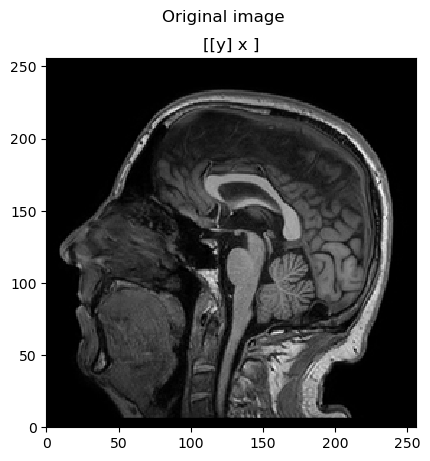

In [2]:
img_original = t1[45]
sigpy.plot.ImagePlot(sigpy.flip(img_original,axes=(2,)),title='Original image')

Generate the foordinates where the k-space will be sampled using `sigpi.mri.radial`. Contraty to what is shown in the project instructions, the spokes don't go across the origin, but rather, they expand from the origin, starting at the positive y-axis and turning clockwise for each consecutive spoke. Since the instructions give a spoke of 256 samples across the origin, we generate our spokes having 128 samples from the origin. To begin with, we acquire 180 spokes, equivalent to 90 of the spokes assumed in the project instructions.

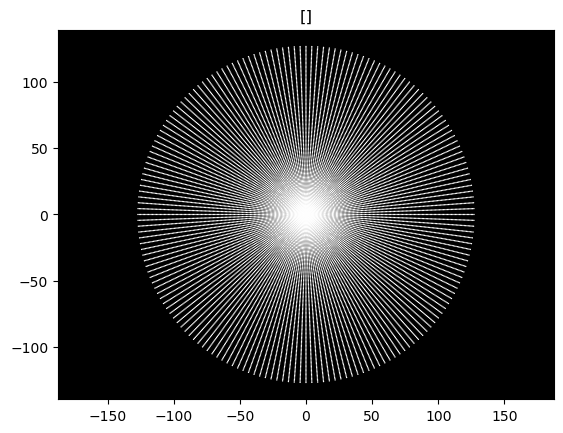

In [3]:
coord = sigpy.mri.radial([180,128,2],[256,256],golden=False)
sigpy.plot.ScatterPlot(coord)

Since the spokes are generated with the origin in the middle, but the image is an array whose pixel at (0,0) lies on the top left corner, we need to translate the spokes set to the center of the image. For this we have created a function to translate the spokes set to the middle pixel of any image:

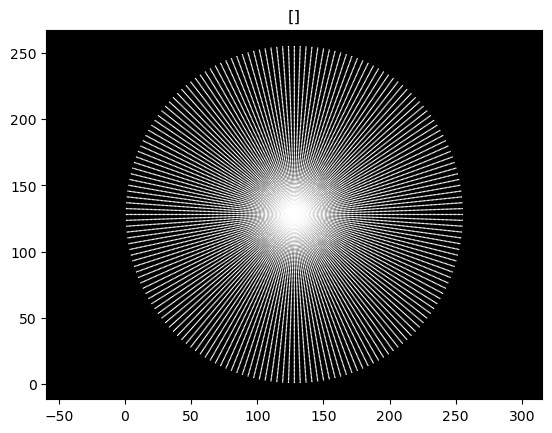

In [4]:
def translate_spokes_to_img_coord(spokes, im_size=(256,256)):
    x_shift = np.floor(im_size[1]/2) # x_shift determines how columns will be shifted
    y_shift = np.floor(im_size[0]/2) # y_shift determines how rows will be shifted
    new_spokes = []
    for spoke in spokes:
        new_spoke = []
        for point in spoke:
            new_point = [point[0] + x_shift, abs(point[1] - y_shift)]
            new_spoke.append(new_point)
        new_spokes.append(new_spoke)
    return np.array(new_spokes)

coord = translate_spokes_to_img_coord(coord)
sigpy.plot.ScatterPlot(coord)

Now we obtain the density compensation factor for the k-space

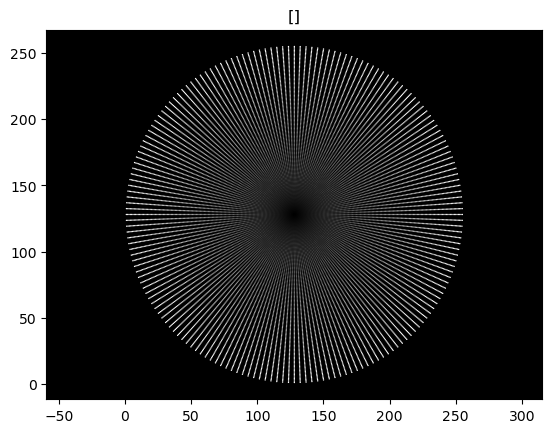

In [5]:
dcf = ((coord[...,0]-128)**2+(coord[...,1]-128)**2)**0.5
sigpy.plot.ScatterPlot(coord,dcf)

We obtain the fourier transform of the image (k-space) and sample it with the coordinates we acquired previously using the sigpy functions `fft` and `interpolate`

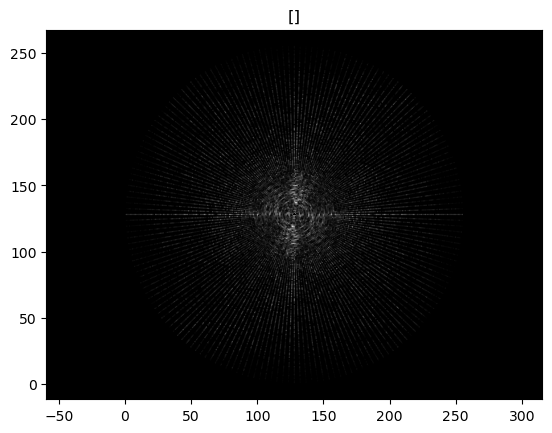

(256, 256)

In [6]:
img_ksp = sigpy.fft(img_original)
sampled_ksp = sigpy.interpolate(img_ksp,coord)
sampled_ksp_compensated = sampled_ksp*dcf
sigpy.plot.ScatterPlot(coord,sampled_ksp_compensated)
img_ksp.shape

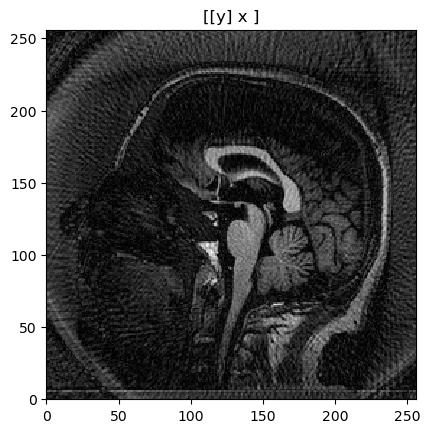

Shape of sampled k-space: (180, 128)
Shape of coordinates: (180, 128, 2)


In [7]:
img_reconstructed = sigpy.nufft_adjoint(sampled_ksp_compensated, coord, oshape=(256,256))
sigpy.plot.ImagePlot(sigpy.flip(img_reconstructed,axes=(2,)))
print(f"Shape of sampled k-space: {sampled_ksp_compensated.shape}")
print(f"Shape of coordinates: {coord.shape}")

### Evaluate the quality of the reconstruction

It has to be noted that the absolute values of the pixels in the reconstructed image are not going to coincide with the scale of the original image. To make signifficant comparisons we need to scale the reconstruction. It is common to normalize the reconstruction by the total energy of the original image. We will do that here:

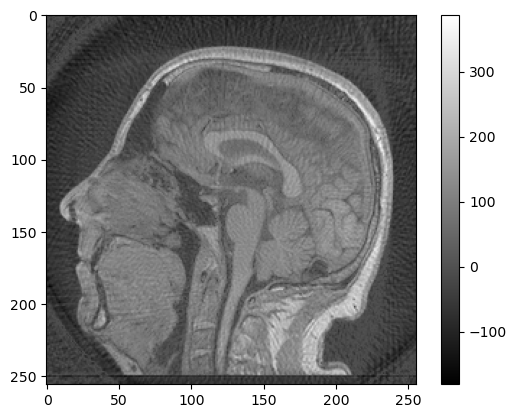

Peak signal-to-noise reatio: 50.852965159685965


In [31]:
from skimage.metrics import peak_signal_noise_ratio as psnr

img_reco_abs = np.abs(img_reconstructed)
scale = np.sqrt(np.sum(img_original**2)/np.sum(img_reco_abs**2))
img_reco_scaled = (img_reco_abs * scale).astype(np.int16)

difference = img_original - img_reco_scaled
plt.imshow(difference, cmap='gray')
plt.colorbar()
plt.show()
print(f"Peak signal-to-noise reatio: {psnr(img_original, img_reco_scaled)}")

Mean structural similarity index = 0.22461859239939214


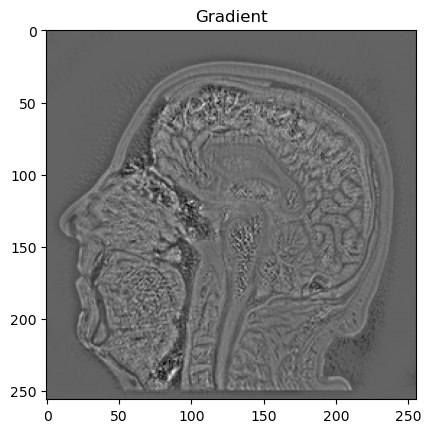

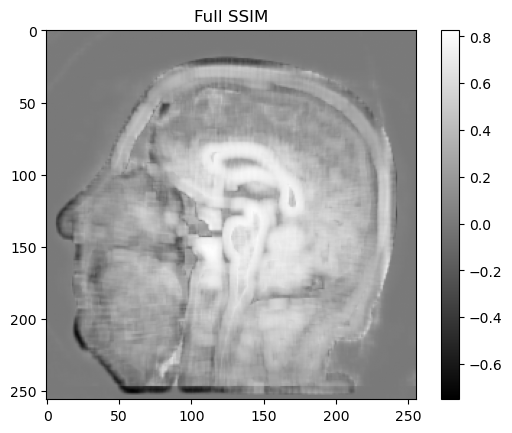

In [29]:
from skimage.metrics import structural_similarity

ssim, grad, S = structural_similarity(img_original, img_reco_scaled, gradient=True, full=True, data_range=(img_original.max() - img_original.min()))
print(f"Mean structural similarity index = {ssim}")
plt.figure()
plt.imshow(grad, cmap='gray')
plt.title("Gradient")
plt.show()

plt.figure()
plt.imshow(S, cmap='gray')
plt.title("Full SSIM")
plt.colorbar()
plt.show()

Now create a function to automate the process of sampling and gridding reconstruction

In [13]:
def radial_sampling(ksp, n_spokes, n_samples=256):
    coord = sigpy.mri.radial([n_spokes,n_samples,2],ksp.shape,golden=False)
    dcf = ((coord[...,0])**2+(coord[...,1])**2)**0.5
    coord = translate_spokes_to_img_coord(coord, ksp.shape)
    sampled = sigpy.interpolate(ksp,coord)
    return (sampled*dcf), coord # Density-compensated sampled k-space and coordinates

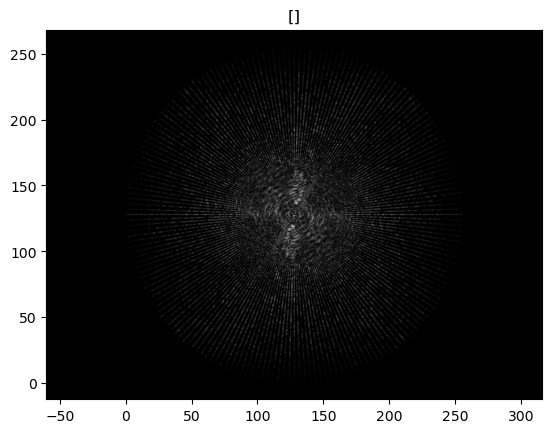

In [16]:
# Test the function
sampled, coord = radial_sampling(img_ksp, 192, 256)
sigpy.plot.ScatterPlot(coord, sampled)

Now define the reconstruction function and an auxilliar function to scale the image

In [ ]:
def scale_reconstruction(reco, original):
    reco = np.abs(reco)
    scale = np.sqrt(np.sum(original**2)/np.sum(reco**2))
    reco = (reco * scale).astype(np.int16)
    return reco

def reconstruct_radial(ksp_sampled, coord):
    reco = sigpy.nufft_adjoint(ksp.sampled, coord, oshape=ksp_sampled.shape)
    return reco

The acceleration factor is determined as the ratio of the number of samples in the complete Cartesian sample and the the number of samples in the radial sampling. The number of points in the radial sampling is given by

$N_\text{radial} = N_\text{spokes} \times N_\text{samples/spoke}$

The total number of samples in a complete Cartesian sampling in an image with dimmensions $W \times H$ is

$N_\text{Cartesian} = W \times H$

In our case, the number of Cartesian samples is $256 \times 256 = 65\,523$.

So, the acceleration factor is given by

$R = \dfrac{N_\text{Cartesian}}{N_\text{radial}} = \dfrac{65\,523}{N_\text{spokes} \times N_\text{samples/spoke}}$.

Let us take a fixed number of samples per spoke $N_\text{samples/spoke} = 256$. This way, the number of spokes required to get a given acceleration factor is

$N_\text{spokes} = \dfrac{65\,523}{R \times 256} = \dfrac{256}{R}$.

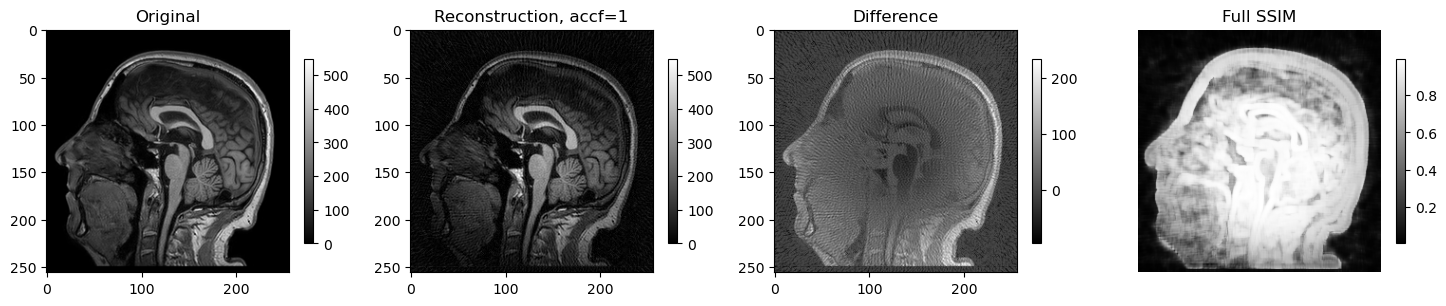

Acceleration factor: 1,    Number of spokes: 256
PSNR = 57.67970107071677,    MSSIM = 0.57234446332206


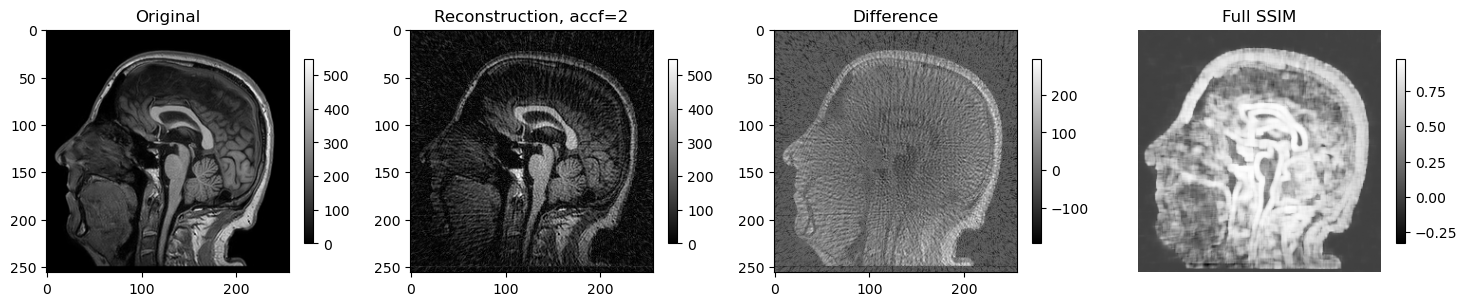

Acceleration factor: 2,    Number of spokes: 128
PSNR = 55.93375572058905,    MSSIM = 0.4268765975433274


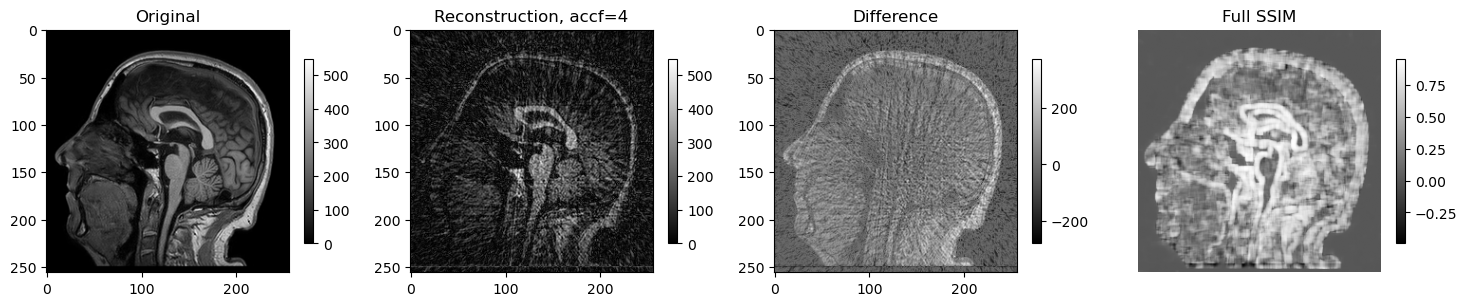

Acceleration factor: 4,    Number of spokes: 64
PSNR = 53.45187654565012,    MSSIM = 0.2920858556457238


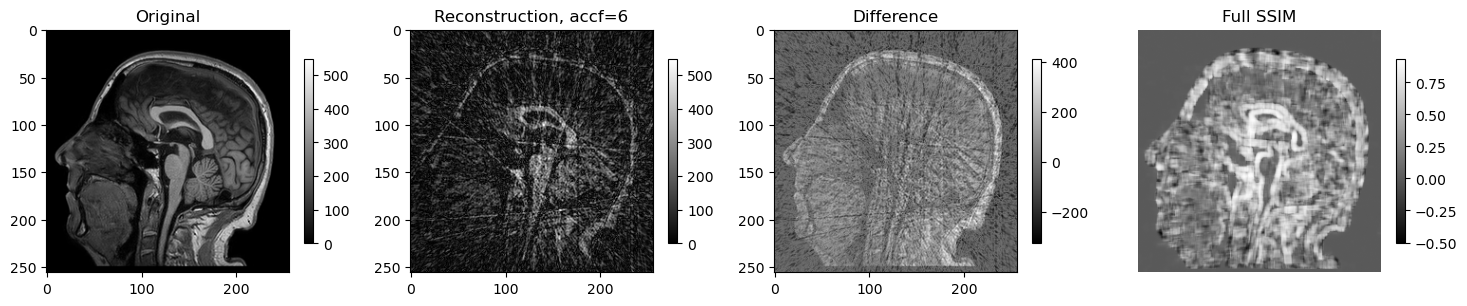

Acceleration factor: 6,    Number of spokes: 42
PSNR = 52.127937795928865,    MSSIM = 0.22057848238784145


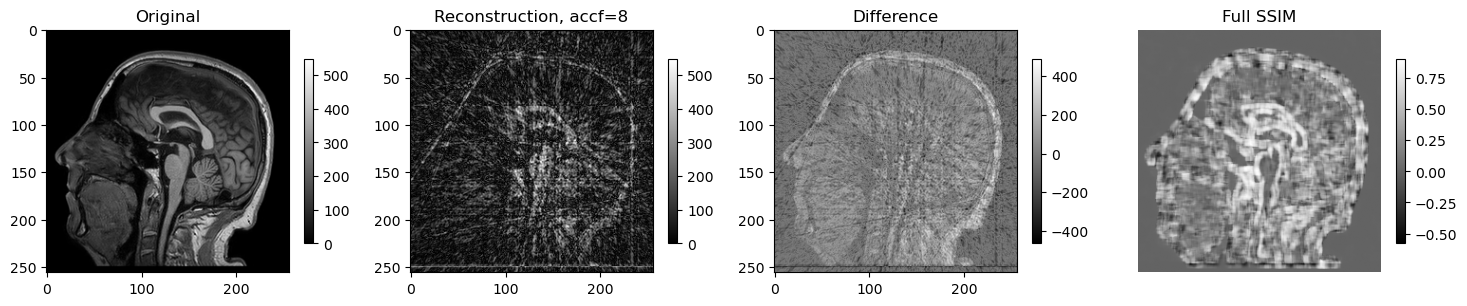

Acceleration factor: 8,    Number of spokes: 32
PSNR = 51.200090477443624,    MSSIM = 0.1818174947498858


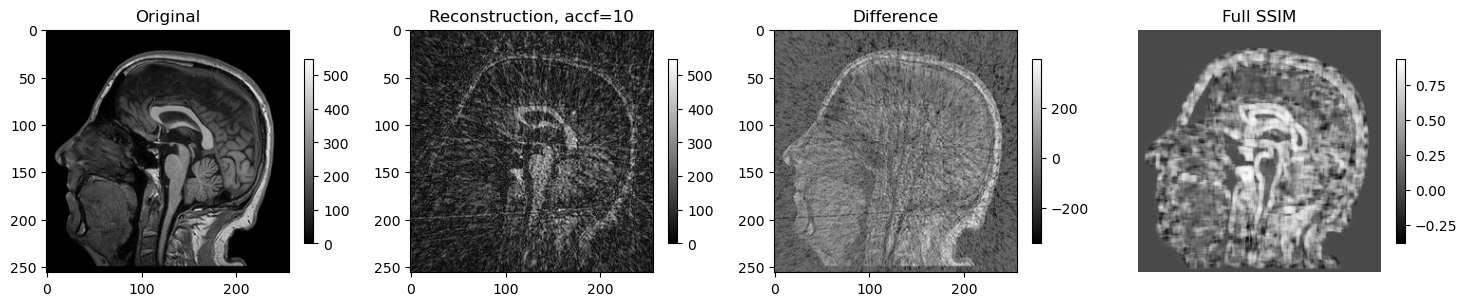

Acceleration factor: 10,    Number of spokes: 25
PSNR = 51.704392145713825,    MSSIM = 0.2163865012903307


In [68]:
# Testing reconstruction with NUFFT 
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import sigpy.mri
import sigpy.plot
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def translate_spokes_to_img_coord(spokes, im_size=(256,256)):
    x_shift = np.floor(im_size[1]/2) # x_shift determines how columns will be shifted
    y_shift = np.floor(im_size[0]/2) # y_shift determines how rows will be shifted
    new_spokes = []
    for spoke in spokes:
        new_spoke = []
        for point in spoke:
            new_point = [point[0] + x_shift, abs(point[1] - y_shift)]
            new_spoke.append(new_point)
        new_spokes.append(new_spoke)
    return np.array(new_spokes)

def radial_sampling(ksp, n_spokes, n_samples=256):
    coord = sigpy.mri.radial([n_spokes,n_samples,2],ksp.shape,golden=False)
    dcf = ((coord[...,0])**2+(coord[...,1])**2)**0.5
    coord = translate_spokes_to_img_coord(coord, ksp.shape)
    sampled = sigpy.interpolate(ksp,coord)
    return (sampled*dcf), coord # Density-compensated sampled k-space and coordinates

def scale_by_energy(reco, original):
    reco = np.abs(reco)
    scale = np.sqrt(np.sum(original**2)/np.sum(reco**2))
    reco = (reco * scale).astype(np.int16)
    return reco

def scale_by_max(reco, original):
    reco = np.abs(reco)
    reco = (reco/reco.max() * original.max()).astype(np.int16)
    return reco

def reconstruct_radial(ksp_sampled, coord, shape=(256,256)):
    reco = sigpy.nufft_adjoint(ksp_sampled, coord, oshape=shape)
    return reco

if __name__ == "__main__":

    sitk_t1=sitk.ReadImage('../files/t1.nii.gz')
    t1=sitk.GetArrayFromImage(sitk_t1)
    original = t1[45]
    ksp = sigpy.fft(original)
    
    acc_factors = np.array([1, 2, 4, 6, 8, 10])
    N_spokes = (256/acc_factors).astype(int)
    
    SNRs = []
    SSIMs = []
    
    for Nsp, acc in zip(N_spokes, acc_factors):
        ksp_sampled, coord = radial_sampling(ksp, Nsp)
        reco = reconstruct_radial(ksp_sampled, coord)
        # print(reco.shape)
        reco = scale_by_max(reco, original)
        # print(reco.shape)
        # Metrics
        difference = original - reco
        psnr = peak_signal_noise_ratio(original, reco)
        ssim, S = structural_similarity(original, reco, full=True, data_range=(original.max() - original.min()))
        # Plot
        fig, axs = plt.subplots(1, 4)
        fig.set_figwidth(18)
        plt.axis('off')
        figs = []
        figs.append(axs[0].imshow(original, cmap='gray',))
        figs.append(axs[1].imshow(reco, cmap='gray'))
        figs.append(axs[2].imshow(difference, cmap='gray'))
        figs.append(axs[3].imshow(S, cmap='gray'))
        for f, a in zip(figs,axs):
            fig.colorbar(f, ax=a, shrink=0.5)
        axs[0].set_title('Original')
        axs[1].set_title(f'Reconstruction, accf={acc}')
        axs[2].set_title('Difference')
        axs[3].set_title('Full SSIM')
        plt.show()
        print(f"Acceleration factor: {acc},    Number of spokes: {Nsp}")
        print(f"PSNR = {psnr},    MSSIM = {ssim}")
        print("============================================================")

The reconstruction was normalized to have the same maximum value as the original, rather than the most common practice to normalize it to have the same total energy as the original image. This because the artifacts in the negative space of the image were impacting too much the mean structural similarity index, although the full SSIM image showed that the relevant details within the head were correctly resolved. 